# Under construction

This tutorial is currently broken.  We're working on fixing it.  Related tickets:

  * https://github.com/desihub/tutorials/issues/33
  * https://github.com/desihub/fiberassign/issues/243
  * https://github.com/desihub/fiberassign/issues/244


In [1]:
import os, sys, subprocess, fitsio, shutil
from collections import Counter

import numpy as np
from astropy.table import Table
from astropy.io import fits

import desimodel.io
import desimodel.focalplane
import desimodel.footprint
from desitarget.targetmask import desi_mask, obsconditions
import matplotlib.pyplot as plt
%matplotlib inline

**Learning goals**

In this notebook you will learn how to:

* Generate mock files from simulations to feed into fiberassign.
* Run fiberassign using the files generated above.
* Explore the outputs of fiberassign to estimate its efficiency.

This notebook has been tested against `desi_environment` 19.2.

This notebook reuses code by S. Bailey https://github.com/desihub/tutorials/blob/master/FiberAssign.ipynb

In [2]:
workdir = os.getenv('SCRATCH') + '/desi/test/fiberassign_mock'
os.makedirs(workdir, exist_ok=True)
outdir = workdir + '/output'
os.makedirs(outdir, exist_ok=True)
shutil.copy('select-mock-targets.yaml', workdir)
os.chdir(workdir)

In [3]:
# This is the content of the configuration file to be passed to select_mock_targets
!cat select-mock-targets.yaml

# Parameter file for desitarget/bin/select_mock_targets, including contaminants.
targets:
    BGS: {
        target_type: BGS,
        mockfile: '{DESI_ROOT}/mocks/bgs/MXXL/full_sky/v0.0.4/BGS_r20.6.hdf5',
        format: durham_mxxl_hdf5,
        magcut: 20.3,
    }
    ELG: {
        target_type: ELG,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/elg_0_inpt.fits',
        format: gaussianfield,
        density: 2200,
    }
    LRG: {
        target_type: LRG,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/lrg_0_inpt.fits',
        format: gaussianfield,
        density: 480,
    }
    QSO: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/DarkSky/v1.0.1/qso_0_inpt.fits',
        format: gaussianfield,
        zmax_qso: 1.8,
        use_simqso: True,
        density: 120,
    }
    LYA: {
        target_type: QSO,
        mockfile: '{DESI_ROOT}/mocks/lya_forest/london/v4.2.0/master.fits',
        format: CoLoRe,
        nside_lya: 16,
        zmin_lya: 1.8,
 

Some more files needed to run fiberassign

In [4]:
mtlfile = os.path.join(workdir, 'mtl.fits')
truthfile = os.path.join(workdir, 'truth.fits')
starfile = os.path.join(workdir, 'std.fits')
targetcutfile = os.path.join(workdir, 'targets.fits') 
skycutfile = os.path.join(workdir, 'sky.fits') 
tilefile = os.path.join(workdir, "tiles.fits")

In [5]:
# tile selection
program = "dark"

tiles = desimodel.io.load_tiles()
bright = tiles['PROGRAM']=='BRIGHT'
    
small = ((tiles['RA']>12) & (tiles['RA']<20) & (tiles['DEC']<1) & (tiles['DEC']>-1))

if program=="bright":
    Table(tiles[(bright)&(small)]).write(tilefile, overwrite=True)
else:
    Table(tiles[(~bright) & (small)]).write(tilefile, overwrite=True)

print("Wrote tiles to {}".format(tilefile))

Wrote tiles to /global/cscratch1/sd/sjbailey/desi/test/fiberassign_mock/tiles.fits


In [7]:
!pwd
!ls

/global/cscratch1/sd/sjbailey/desi/test/fiberassign_mock
output	select-mock-targets.yaml  tiles.fits


In [8]:
cmd = "srun -A desi -N 2 -n 16 -c 8"  # -c 8 not 4 for hyperthreading
cmd += " -C haswell -t 01:00:00 --qos interactive "
cmd += " mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10"
cmd += " -c ./select-mock-targets.yaml "
cmd += " --output_dir ./ "
cmd += " --tiles ./tiles.fits"
print(cmd)

srun -A desi -N 2 -n 16 -c 8 -C haswell -t 01:00:00 --qos interactive  mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10 -c ./select-mock-targets.yaml  --output_dir ./  --tiles ./tiles.fits


In [9]:
# To run target selection comment out these lines. it should take <15 minutes
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    # print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    raise ex

RUNNING: srun -A desi -N 2 -n 16 -c 8 -C haswell -t 01:00:00 --qos interactive  mpi_select_mock_targets --no-spectra --nproc 4 --nside 32 --seed 10 -c ./select-mock-targets.yaml  --output_dir ./  --tiles ./tiles.fits
Launched in background. Redirecting stdin to /dev/null
INFO:mpi_select_mock_targets:84:<module>: 15 tiles
INFO:mpi_select_mock_targets:99:<module>: 19/19 pixels remaining to do
INFO:mpi_select_mock_targets:147:<module>: rank 0 processes 1 pixels [4493]
INFO:mpi_select_mock_targets:147:<module>: rank 1 processes 1 pixels [4495]
INFO:mpi_select_mock_targets:147:<module>: rank 3 processes 1 pixels [4498]
INFO:mpi_select_mock_targets:147:<module>: rank 5 processes 2 pixels [4500 4501]
INFO:mpi_select_mock_targets:147:<module>: rank 9 processes 1 pixels [4505]
INFO:mpi_select_mock_targets:147:<module>: rank 7 processes 1 pixels [4503]
INFO:mpi_select_mock_targets:147:<module>: rank 2 processes 1 pixels [4497]
INFO:mpi_select_mock_targets:147:<module>: rank 4 processes 1 pixels 

In [11]:
cmd = 'join_mock_targets --overwrite --mockdir ./'
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    raise ex

RUNNING: join_mock_targets --overwrite --mockdir ./
INFO:build.py:1129:_merge_file_tables: Generating .//sky.fits from .//*/*/sky-*.fits HDU SKY_TARGETS
INFO:build.py:1169:_merge_file_tables: Writing .//sky.fits SKY_TARGETS
INFO:build.py:1129:_merge_file_tables: Generating .//targets-bright.fits from .//*/*/bright/targets-*.fits HDU TARGETS
INFO:build.py:1169:_merge_file_tables: Writing .//targets-bright.fits TARGETS
INFO:build.py:1129:_merge_file_tables: Generating .//truth-bright.fits from .//*/*/bright/truth-*.fits HDU TRUTH
INFO:build.py:1169:_merge_file_tables: Writing .//truth-bright.fits TRUTH
INFO:build.py:1129:_merge_file_tables: Generating .//truth-bright.fits from .//*/*/bright/truth-*.fits HDU TRUTH_BGS
INFO:build.py:1169:_merge_file_tables: Writing .//truth-bright.fits TRUTH_BGS
INFO:build.py:1129:_merge_file_tables: Generating .//truth-bright.fits from .//*/*/bright/truth-*.fits HDU TRUTH_ELG
INFO:build.py:1148:_merge_file_tables: Extension TRUTH_ELG not found in ./44/449

Text(0,0.5,'DEC')

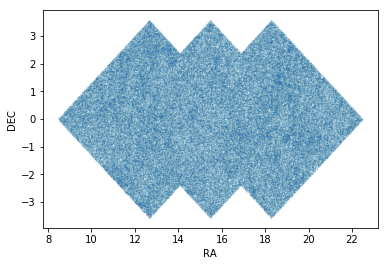

In [14]:
mtldata = Table.read('mtl-dark.fits')
plt.scatter(mtldata['RA'], mtldata['DEC'],s=0.1, alpha=0.1)
plt.xlabel('RA')
plt.ylabel('DEC')

In [17]:
# Run fiberassign
cmd = 'fiberassign --overwrite --mtl mtl-dark.fits --sky sky.fits'
cmd += ' --footprint ./tiles.fits'
cmd += ' --outdir ./output/'
cmd = cmd.format(outdir=outdir)

In [18]:
print('RUNNING: '+cmd)
try:
    results = subprocess.check_output(cmd.split(), stderr=subprocess.STDOUT)
    print(results.decode())
    # print('--- SUCCESS ---')
except subprocess.CalledProcessError as ex:
    print('--- ERROR {} ---'.format(ex.returncode))
    print(ex.output.decode())
    raise ex

RUNNING: fiberassign --overwrite --mtl mtl-dark.fits --sky sky.fits --footprint ./tiles.fits --outdir ./output/


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



CalledProcessError: Command '['fiberassign', '--overwrite', '--mtl', 'mtl-dark.fits', '--sky', 'sky.fits', '--footprint', './tiles.fits', '--outdir', './output/']' returned non-zero exit status 1.

In [ ]:
!ls output

In [ ]:
tiles = Table.read("tiles.fits")
targets = Table.read("mtl.fits")

In [ ]:
# Gather all outputs
assignments = list()
for tileid in tiles['TILEID']:
    tilefile = '{}/tile-{:05d}.fits'.format(outdir, tileid)
    assignments.append(Table.read(tilefile, hdu=1))
    
assigned_targetids = np.concatenate([tmp['TARGETID'] for tmp in assignments])
isAssigned = np.in1d(targets['TARGETID'], assigned_targetids)

plt.figure(figsize=(12,4))
plt.plot(targets['RA'][isAssigned], targets['DEC'][isAssigned], 'k,')
plt.title('Targets assigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(targets['RA'][~isAssigned], targets['DEC'][~isAssigned], 'k,')
plt.title('Targets left unassigned to fibers')
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')